# LYRA arepo reader information

Let's begin by loading the modules we will be using. This is standrasd packages like numpy, scipy and matpltoin. Along with arepo_util, which will use to load the simualtion data.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import arepo_utils as ar

Let's also specify the path to simulation data, and name of the original lyra haloes. And the nuber of snapshots in each file.

In [2]:
loc = '/cosma8/data/dp004/lyra/original_sample/'
suffix = '/output/'
halo = 'T1_Aug'

We'll begin the analysis by loading some unformaiton about the galaxies and haloes in the simulation. We start by initialising the arepo readers for the halo information as follows. 

In [3]:
#load T1_Aug
snap_num = 187
sf = ar.gadget_subfind.load_subfind(snap_num, dir=loc + halo + suffix)

We can see what data is available to us by printing all the available keys. 

In [4]:
print(sf.data.keys())

dict_keys(['fgcm', 'ffsh', 'fgmf', 'fgmt', 'flen', 'flty', 'fmas', 'fmty', 'fnsh', 'fpos', 'fsfr', 'fsmf', 'fsmt', 'fvel', 'fmc2', 'fmc5', 'fmm2', 'fmt2', 'frc2', 'frc5', 'frm2', 'frt2', 'scmp', 'sgmf', 'sgmh', 'sgmx', 'sgms', 'sgmw', 'sgmt', 'sgth', 'sgtx', 'sgts', 'sgtw', 'sgnr', 'shmr', 'shmt', 'sidm', 'slen', 'slty', 'smas', 'smih', 'smht', 'smim', 'smmt', 'smir', 'smit', 'smty', 'sprt', 'spos', 'ssfr', 'sshr', 'ssxr', 'ssfi', 'sspi', 'ssmf', 'ssfh', 'ssfx', 'ssmt', 'ssth', 'sstx', 'svel', 'svdi', 'svmx', 'svrx'])


Don't worry about most of these. There's much more than we will use throughout the project. Let's start by looking at the masses of these haloes, and their positions.

In [5]:
pos = sf.data['spos']
mass = sf.data['smty']

print(pos.shape, mass.shape)

(121850, 3) (121850, 6)


Here we see that each array has a length of 121850. This is the number of identified (sub)haloes in the simulations. Each halo has a position (x,y,z), and six particle types for its halo mass.

We want to throw away haloes with low resltuion particles in them. Low resoltuion partiucle belong to type 2 and 3. Let's visualtise their distribtuion.

Text(0.5, 0, 'x [Mpc]')

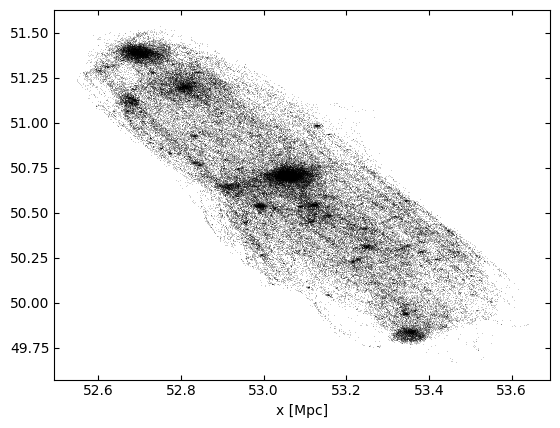

In [6]:
cut = (mass[:,2]==0) & (mass[:,3]==0)
plt.plot(pos[cut,0], pos[cut,1], 'k,',alpha = 0.2)
plt.xlabel('x [Mpc]')

We can also look at the gas mass as a function of a haloes dark matter mass. Gas is type 0, DM type 1.

Text(0, 0.5, 'Gas mass [10^10 Msun]')

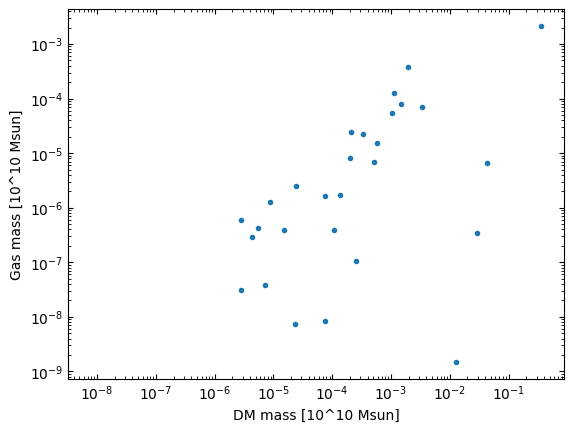

In [7]:
plt.plot(mass[cut,1], mass[cut,0],'.')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('DM mass [10^10 Msun]')
plt.ylabel('Gas mass [10^10 Msun]')

We see that in general more massive haloes, i.e. those with more DM, contain more gas.

Let's now also load in some of the simulation particle data. These data sets are much larger so be careful to only load the data you need. We'll begin by loading the particle positions and densities of the gas (particle type 0) for the most massive halo (halo 0). Also we will specify that the file type is hdf5, adn we want to use 'lazy laod'.

In [8]:
sn = ar.gadget_snap.gadget_snapshot(loc + halo + suffix + 'snapdir_187/snapshot_187',loadonlytype=[0], loadonlyhalo = 0, subfind = sf, hdf5=True, lazy_load=True)
print(sn.data.keys())

dict_keys(['ref', 'pos', 'rho', 'ne', 'gcol', 'gz', 'gmet', 'hrgm', 'u', 'mass', 'nh', 'id', 'sfr', 'vel', 'vol', 'type'])


Again, there are many different properties of the particles. Far more than we will use in this project. Let's begin by looking at their positions and densities.

Text(0.5, 0, 'density [10^10 Msun /Mpc**3]')

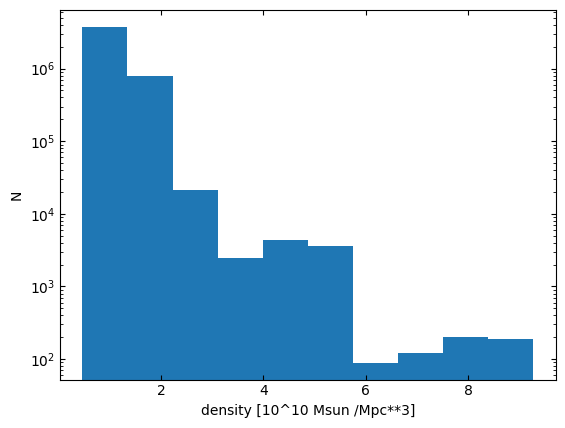

In [9]:
plt.hist(np.log10(sn.data['rho']))
plt.yscale('log')

plt.ylabel('N')
plt.xlabel('density [10^10 Msun /Mpc**3]')

We can also visualise the spatial distribution of this gas. (There are a lot of data points to plot, so this will take a little while)

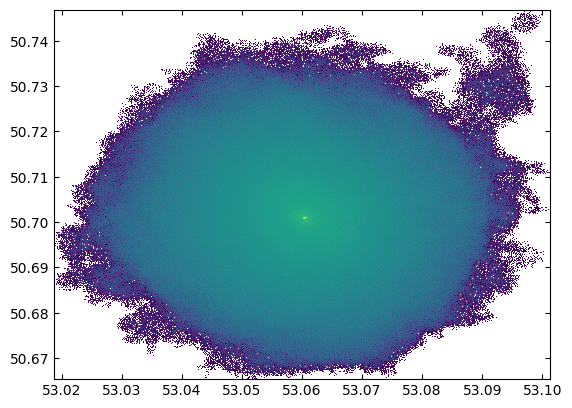

In [10]:
#sort data by density, so most dense gas sits on top of plot
import matplotlib as mpl

out = plt.hist2d(sn.data['pos'][:,0], sn.data['pos'][:,1], norm=mpl.colors.LogNorm(), bins = 512)
